In [165]:
# Загружаем картинки
from os import listdir, walk
from os.path import isfile, join
def take_all_pictures_names(path):
    paths = []
    targets = []
    for x in walk(path):
        for y in x[2]:
            if (y.find('depth') == -1):
                paths.append(x[0] + '/' + y)
                targets.append(x[0][len(x[0]) - 1:])
    return paths, targets

def get_all_pictures(path, a, b):
    X = []
    y = []
    names, targets = take_all_pictures_names(path)
    for ind, (name, target) in enumerate(zip(names, targets)):
        if (ind >= a and ind < b):
            X.append(plt.imread(name))
            y.append(target)
    return X, y

def get_pictures_in_range(path, ind_range):
    X = []
    y = []
    names, targets = take_all_pictures_names(path)
    count = 0
    print('all_pictures on disk:', len(names))
    for i in ind_range:
        X.append(plt.imread(names[i]))
        y.append(targets[i])
        count += 1
        if (count % 500 == 0):
            print(count)
    return X, y

#Показать картинку
def show_picture(number):
    print(y[number], X[number].shape)
    plt.imshow(X[number])
    
# Меняем размер картинки
from skimage.transform import resize
def resize_picture(img, shape):
    return resize(img, shape, mode='constant')

In [79]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.datasets import mnist
%matplotlib inline

## Получим хоть какой-то кусочек данных

In [82]:
# Так можно загружать даннные в X, y
%time X, y = get_pictures_in_range('/media/ilya/DATA/sign_recognition_data/dataset5/', range(1, 40000, 8))

CPU times: user 10.3 s, sys: 816 ms, total: 11.1 s
Wall time: 54.9 s


In [90]:
print(len(X), len(X_test))

5000 1000


In [ ]:
# Довольно оптимистичный тест, потому что кадры очень близки
%time X_test, y_test = get_pictures_in_range('/media/ilya/DATA/sign_recognition_data/dataset5/', range(4, 40000, 40))

In [88]:
X_test = np.array([resize_picture(x, (60, 60, 3)) for x in X_test])

In [91]:
X_p_test = X_test.reshape(1000, 60 * 60 * 3)
X_p = X.reshape(5000, 60 * 60 * 3)

In [92]:
# Изменим размер всей картинок на (60, 60, 3)
X = [resize_picture(x, (60, 60, 3)) for x in X]

o (60, 60, 3)


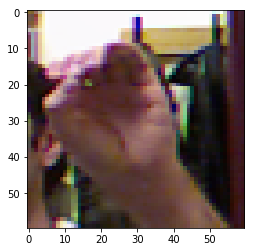

In [93]:
show_picture(900)

In [94]:
X = np.array(X)
X.shape

(5000, 60, 60, 3)

## Теперь данные из совсем другого датасета

In [206]:
def filter_other_data(X, Y):
    X_filter, y_filter = [], []
    for x, y in zip(X, Y):
        y_lower = y.lower()
        if (y_lower in ['a', 'b', 'c', 'v']):
            X_filter.append(x)
            y_filter.append(y_lower)
    return X_filter, y_filter

all_pictures: 4873
500
CPU times: user 404 ms, sys: 16 ms, total: 420 ms
Wall time: 417 ms
['A' 'B' 'C' 'V' 'e' 't']
c
(565, 10800) 565


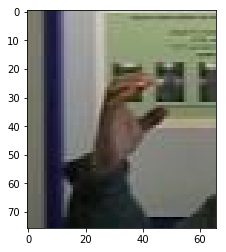

In [212]:
%time X_other, y_other = get_pictures_in_range('../Training/', range(1, 4800, 5))
print(np.unique(y_other))

X_filter_other, y_filter_other = filter_other_data(X_other, y_other)
X_other = X_filter_other
y_other = y_filter_other

print(y_filter_other[300])
plt.imshow(X_filter_other[300])

X_other = np.array([resize_picture(x, (60, 60, 3)) for x in X_other])
X_other_p = X_other.reshape((len(X_other), 60 * 60 * 3))
print(X_other_p.shape, len(y_other))

### Здесь будет предобработка данных

# PCA and SVM

In [200]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

def fit_pca(X, n_comp):
    pca = PCA(n_components=n_comp)
    return pca.fit(X)

def fit_svm(X, y, C, gamma):
    svm = SVC(C = C, random_state=241, gamma=gamma)
    return svm.fit(X, y)

def fit_pca_svm(X, y, n_comp=100, C = 2, gamma=0.0001):
    pca = fit_pca(X, n_comp=n_comp)
    smv = fit_svm(pca.transform(X), y, C = C, gamma=gamma)
    return (pca, svm)

def fit_get_score_pca_svm(X, y, X_test, y_test, n_comp, C, gamma):
    pca = fit_pca(X, n_comp=n_comp)
    X_tr = pca.transform(X)
    X_test_tr = pca.transform(X_test)
    print(pca.explained_variance_ratio_[:min(n_comp, 20)])
    
    svm = fit_svm(X_tr, y, C = C, gamma = gamma)
    print(svm)
    print('support vectors count:', len(svm.support_))
    print('train score:', accuracy_score(y, svm.predict(X_tr)))
    print('test score:', accuracy_score(y_test, svm.predict(X_test_tr)))
    
    return (pca, svm)

def get_score_pca_svm(pca, svm, X, y):
    X_tr = pca.transform(X)
    y_pred = svm.predict(X_tr)
    return accuracy_score(y, y_pred)

In [214]:
%time pca1, svm1 = fit_get_score_pca_svm(X_p, y, X_p_test, y_test, n_comp=500, C = 2, gamma=0.0001)

print('other dataset:', get_score_pca_svm(pca1, svm1, X_other_p, y_other))

[ 0.20346227  0.08636973  0.06467943  0.04687693  0.03357617  0.02995818
  0.02523407  0.01991529  0.01853299  0.0163469   0.01458185  0.01408894
  0.01332348  0.01175724  0.01082084  0.00993546  0.00879874  0.00828689
  0.00749354  0.00726734]
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=241, shrinking=True,
  tol=0.001, verbose=False)
support vectors count: 4787
train score: 0.742
test score: 0.704
CPU times: user 1min 5s, sys: 80 ms, total: 1min 5s
Wall time: 53.2 s
other dataset: 0.129203539823


In [202]:
svm1

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=241, shrinking=True,
  tol=0.001, verbose=False)